# **Data Processing**


In [1]:
import re
import nltk
import pandas as pd
import csv
import spacy

**Reading tsv and fixing collisions**

In [2]:
def open_tsv_file(filename):
    rows = []
    with open(filename, "r") as file:
        for line in file:
            fields = line.strip().split("\t")
            # Check if the line contains more than three fields (indicating a combined line)
            if len(fields) > 3:
                match = re.match(r"(.*?)(Yes|No)(\d+)", fields[2])
                if match:
                    class_label = match.group(2)
                    next_sentence_id = match.group(3)
                    # Append two separate rows with corrected structure
                    rows.append([fields[0], fields[1], class_label])
                    rows.append([next_sentence_id, fields[3], fields[4]])
            else:
                rows.append(fields)
    return rows


rows = open_tsv_file("../data/raw/CT24_checkworthy_english_train.tsv")
train_df = pd.DataFrame(rows[1:], columns=["sentence_id", "text", "class_label"])
train_df.head()

,sentence_id,text,class_label
0,30313,And so I know that this campaign has caused so...,No
1,19099,"""Now, let's balance the budget and protect Med...",No
2,33964,I'd like to mention one thing.,No
3,16871,I must remind him the Democrats have controlle...,Yes
4,13150,"""And to take a chance uh - now be - and not ma...",No


# Data exploration



*   Check for any missing values.
*   Examine the distribution of class labels to see if there's class imbalance
*   Explore the length of the text data to understand its distribution.  



In [3]:
def data_exploration(train_df):
    # Check for any missing values
    missing_values = train_df.isnull().sum()
    print("Missing values:\n", missing_values)

    # Examine the distribution of class labels
    class_distribution = train_df["class_label"].value_counts(normalize=True)
    print("\nClass distribution:\n", class_distribution)

    # Explore the length of the text data
    text_length = train_df["text"].apply(lambda x: len(x.split()))
    print("\nText length statistics:")
    print("Mean:", text_length.mean())
    print("Median:", text_length.median())
    print("Minimum:", text_length.min())
    print("Maximum:", text_length.max())
    return


data_exploration(train_df)

Missing values:
 sentence_id    0
text           0
class_label    0
dtype: int64

Class distribution:
 class_label
No     0.759433
Yes    0.240567
Name: proportion, dtype: float64

Text length statistics:
Mean: 17.943602506555266
Median: 14.0
Minimum: 1
Maximum: 152


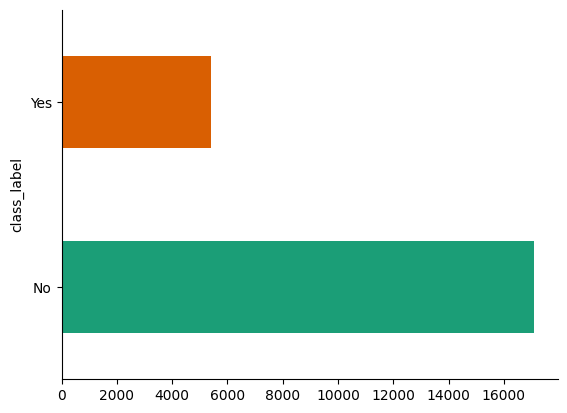

In [4]:
# @title class_label

from matplotlib import pyplot as plt
import seaborn as sns

train_df.groupby("class_label").size().plot(
    kind="barh", color=sns.palettes.mpl_palette("Dark2")
)
plt.gca().spines[
    [
        "top",
        "right",
    ]
].set_visible(False)

# **Essential preprocessing**
1.   Normalization (additionally: Named Entity Recognition (NER),Part-of-Speech (POS) Taggin)  
2.   Tokenization (XLM-RoBERTa tokenizer)
3.   Saving the processed train data for further use

# Feature Engineering

  Once the text is normalized, adding feature engineering techniques to enhance the dataset.    
  
  Word Count: It counts the number of words in each text.
  
  Sentiment Polarity: It measures the sentiment polarity (positive, negative, or neutral) of the text using TextBlob.
  
  Subjectivity: It measures the subjectivity (opinionated vs. factual) of the text using TextBlob.


In [5]:
from textblob import TextBlob

# Load the spaCy model for lemmatization and named entity recognition (NER)
nlp = spacy.load("en_core_web_sm")

# Pre-compile regular expressions
contractions = {
    r"n't": " not",
    r"'s": " is",
    r"'m": " am",
    r"'re": " are",
    r"'ll": " will",
    r"'ve": " have",
    r"'d": " would",
}
contractions_re = re.compile(r"|".join(contractions.keys()))

special_chars_re = re.compile(r"[^a-zA-Z0-9\s]")

# Custom stopword list
custom_stopwords = {"the", "and", "to", "of", "in", "for", "a", "on", "is", "at", "it"}


def normalize_text(text):
    # Handle contractions and possessive forms
    text = contractions_re.sub(lambda m: contractions[m.group(0)], text)

    # Remove special characters except letters, numbers, and spaces
    text = special_chars_re.sub("", text)

    # Perform lemmatization
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])

    return lemmatized_text


def count_words(text):
    return len(text.split())


def compute_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity


def compute_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity


def full_feature_engineering(df):
    # Apply normalization
    df["text"] = df["text"].apply(normalize_text)

    # Batch processing for sentiment analysis
    df["sentiment"] = df["text"].apply(compute_sentiment)
    df["subjectivity"] = df["text"].apply(compute_subjectivity)

    # Count words
    df["word_count"] = df["text"].apply(count_words)

    return df


# Apply feature engineering
train_df = full_feature_engineering(train_df)

# Save preprocessed data
train_df.to_csv("../data/processed/preprocessed_train.tsv", sep="\t", index=False)

print(train_df.head())

  sentence_id                                               text class_label  \
0       30313  and so I know that this campaign have cause so...          No   
1       19099  now let be balance the budget and protect Medi...          No   
2       33964                  I would like to mention one thing          No   
3       16871  I must remind he the Democrats have control th...         Yes   
4       13150  and to take a chance uh   now be   and not mak...          No   

   sentiment  subjectivity  word_count  
0        0.5      0.500000          22  
1        0.0      0.000000          14  
2        0.0      0.000000           7  
3        0.0      0.066667          22  
4        0.8      0.750000          32  


# **Preprocessing for Evaluation**

For other files (dev.tsv and dev-test.tsv), since they contain only two columns (sentence_id and text).

*   Preprocess the dev_df and dev_test_df dataframes using the existing functions.
*   Save the processed data into separate TSV files (processed_dev.tsv and processed_dev_test.tsv) for evaluation.

In [6]:
def preprocess_texts_batch(texts):
    # Normalize text
    normalized_texts = [normalize_text(text) for text in texts]
    return normalized_texts


def preprocess_dev_data(df):
    # Batch processing for normalization
    df["text"] = preprocess_texts_batch(df["text"])

    # Feature engineering
    full_feature_engineering(df)
    return df


def save_processed_dev_data(df, filepath):
    df.to_csv(filepath, sep="\t", index=False)


# Load dev.tsv file
dev_df = pd.read_csv("../data/raw/CT24_checkworthy_english_dev.tsv", sep="\t")
dev_df.columns = map(str.lower, dev_df.columns)

# Load dev-test.tsv file
dev_test_df = pd.read_csv("../data/raw/CT24_checkworthy_english_dev-test.tsv", sep="\t")
dev_test_df.columns = map(str.lower, dev_test_df.columns)

# Preprocessing dev_df
processed_dev_data = preprocess_dev_data(dev_df)
save_processed_dev_data(processed_dev_data, "../data/processed/processed_dev.tsv")

# Preprocessing dev_test_df
processed_dev_test_data = preprocess_dev_data(dev_test_df)
save_processed_dev_data(
    processed_dev_test_data, "../data/processed/processed_dev_test.tsv"
)

# **Tokenization for XML-RoBERTa-Large**

In [7]:
from transformers import XLMRobertaTokenizer

# Initialize the XLM-RoBERTa tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")


def tokenize_text(text):
    tokenized_text = tokenizer(text, truncation=True, padding="max_length", return_tensors="pt", max_length=128)
    return tokenized_text


# Tokenization for XLM-RoBERTa-Large
train_df["tokenized_text"] = train_df["text"].apply(tokenize_text)
dev_df["tokenized_text"] = dev_df["text"].apply(tokenize_text)
dev_test_df["tokenized_text"] = dev_test_df["text"].apply(tokenize_text)

train_df["class_label"] = train_df["class_label"].apply(
    lambda x: 1 if x == "Yes" else 0
)
dev_df["class_label"] = dev_df["class_label"].apply(lambda x: 1 if x == "Yes" else 0)
dev_test_df["class_label"] = dev_test_df["class_label"].apply(
    lambda x: 1 if x == "Yes" else 0
)


train_df

,sentence_id,text,class_label,sentiment,subjectivity,word_count,tokenized_text
0,30313,and so I know that this campaign have cause so...,0,0.50,0.500000,22,"[input_ids, attention_mask]"
1,19099,now let be balance the budget and protect Medi...,0,0.00,0.000000,14,"[input_ids, attention_mask]"
2,33964,I would like to mention one thing,0,0.00,0.000000,7,"[input_ids, attention_mask]"
3,16871,I must remind he the Democrats have control th...,1,0.00,0.066667,22,"[input_ids, attention_mask]"
4,13150,and to take a chance uh now be and not mak...,0,0.80,0.750000,32,"[input_ids, attention_mask]"
...,...,...,...,...,...,...,...
22496,29631,it would be squander too believe I,0,0.00,0.000000,7,"[input_ids, attention_mask]"
22497,7136,we be not allow to vote on it,1,0.00,0.000000,8,"[input_ids, attention_mask]"
22498,181,More Americans at work today than any time in ...,1,0.65,0.625000,17,"[input_ids, attention_mask]"
22499,12863,we indicate at that time that we be not go to ...,1,-0.10,0.100000,13,"[input_ids, attention_mask]"


In [8]:
import json


def convert_to_lists(tokenized_text):
    return {key: value.tolist() for key, value in tokenized_text.items()}


# Convert tokenized data to lists
train_df["tokenized_text"] = train_df["tokenized_text"].apply(convert_to_lists)
dev_df["tokenized_text"] = dev_df["tokenized_text"].apply(convert_to_lists)
dev_test_df["tokenized_text"] = dev_test_df["tokenized_text"].apply(convert_to_lists)

train_tokenized_lists = train_df["tokenized_text"]
dev_tokenized_lists = dev_df["tokenized_text"]
dev_test_tokenized_lists = dev_test_df["tokenized_text"]

# Save tokenized data to JSON files
train_tokenized_lists.to_json(
    "../data/tokenized/train_tokenized.json", orient="records", lines=True
)
dev_tokenized_lists.to_json(
    "../data/tokenized/dev_tokenized.json", orient="records", lines=True
)
dev_test_tokenized_lists.to_json(
    "../data/tokenized/dev_test_tokenized.json", orient="records", lines=True
)

In [9]:
def add_ids_and_mask(row):
    row["input_ids"] = row["tokenized_text"]["input_ids"]
    row["attention_mask"] = row["tokenized_text"]["attention_mask"]
    del row["tokenized_text"]
    return row


train_df = train_df.apply(add_ids_and_mask, axis=1)
dev_df = dev_df.apply(add_ids_and_mask, axis=1)
dev_test_df = dev_test_df.apply(add_ids_and_mask, axis=1)

In [10]:
train_df.to_csv("../data/processed/processed_train_complete.csv")
dev_df.to_csv("../data/processed/processed_dev_complete.csv")
dev_test_df.to_csv("../data/processed/processed_dev_test_complete.csv")